In [ ]:
##EDA AND FEATURE ENGINEERING

In [ ]:
#EDA

In [10]:
from config import DATABASE_NAME, BUCKET, REGION, S3_STAGING_DIR

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from pyathena import connect
from matplotlib.ticker import MaxNLocator


# Project constants
region = REGION   # change if needed
database_name = DATABASE_NAME
bucket =  BUCKET
s3_staging_dir=S3_STAGING_DIR


s3_staging_dir = s3_staging_dir=s3_staging_dir

conn = connect(
    region_name=region,
    s3_staging_dir=S3_STAGING_DIR
)


In [12]:
##Verify Athena Tables
pd.read_sql(f"SHOW TABLES IN {database_name}", conn)

/tmp/ipykernel_523/3685641203.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(f"SHOW TABLES IN {database_name}", conn)


,tab_name
0,holidays_events
1,oil
2,stores
3,train_sales
4,transactions


In [13]:
pd.read_sql(
    f"""
    SELECT MIN(date) AS min_date, MAX(date) AS max_date
    FROM retail_forecasting.train_sales
    """,
    conn
)


/tmp/ipykernel_523/831655993.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(


,min_date,max_date
0,2013-01-01,2017-08-15


In [51]:
'''We will do EDA in 3 layers:

Individual tables (sanity + patterns)

Time behavior (seasonality, trends)

Cross-table insights (before merging)'''


'We will do EDA in 3 layers:\n\nIndividual tables (sanity + patterns)\n\nTime behavior (seasonality, trends)\n\nCross-table insights (before merging)'

In [52]:
##EDA for train.csv

In [14]:
#QUICK CHECK

query = f"""
SELECT date, store_nbr, family, sales, onpromotion
FROM {database_name}.train_sales
WHERE CAST(date AS DATE) BETWEEN DATE '2014-01-01' AND DATE '2017-06-30'
"""

# Read SQL query into pandas DataFrame
train_df = pd.read_sql(query, conn)

# Convert date column to datetime in pandas
train_df['date'] = pd.to_datetime(train_df['date'])

# Preview the DataFrame
print(train_df.head())



/tmp/ipykernel_523/2989737466.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  train_df = pd.read_sql(query, conn)


        date  store_nbr               family  sales  onpromotion
0 2014-04-23         40             HARDWARE    1.0            0
1 2014-04-23         40   HOME AND KITCHEN I    0.0            0
2 2014-04-23         40  HOME AND KITCHEN II    0.0            0
3 2014-04-23         40      HOME APPLIANCES    0.0            0
4 2014-04-23         40            HOME CARE    0.0            0


In [15]:
#Basic info
print("================Basic Info=========================")
print(train_df.info())

# First few rows
print("===================First 5 rows=============================")
print(train_df.head())

# Summary statistics
print("===================Summary Statistics====================================")
print(train_df.describe())

# Check for missing values
print("===================Check for missing values=============================")
print(train_df.isnull().sum())

================Basic Info=========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270268 entries, 0 to 2270267
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 86.6+ MB
None
===================First 5 rows=============================
        date  store_nbr               family  sales  onpromotion
0 2014-04-23         40             HARDWARE    1.0            0
1 2014-04-23         40   HOME AND KITCHEN I    0.0            0
2 2014-04-23         40  HOME AND KITCHEN II    0.0            0
3 2014-04-23         40      HOME APPLIANCES    0.0            0
4 2014-04-23         40            HOME CARE    0.0            0
===================Summary Statistics==============================

In [ ]:
##Analyze the target variable sales

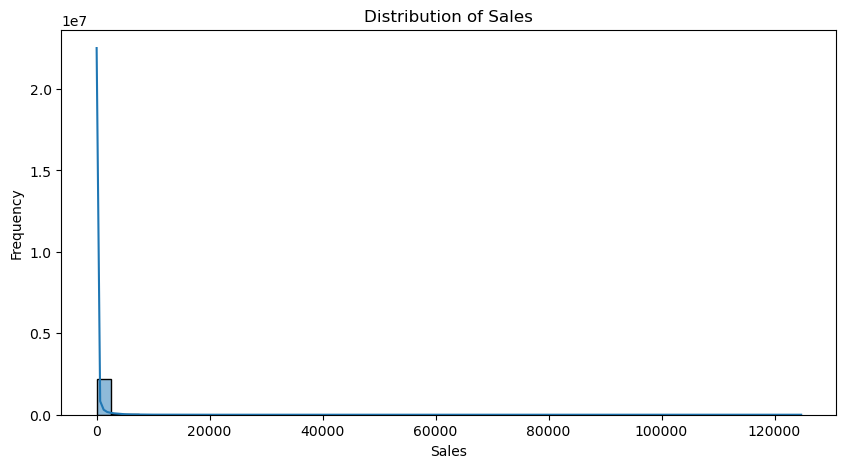

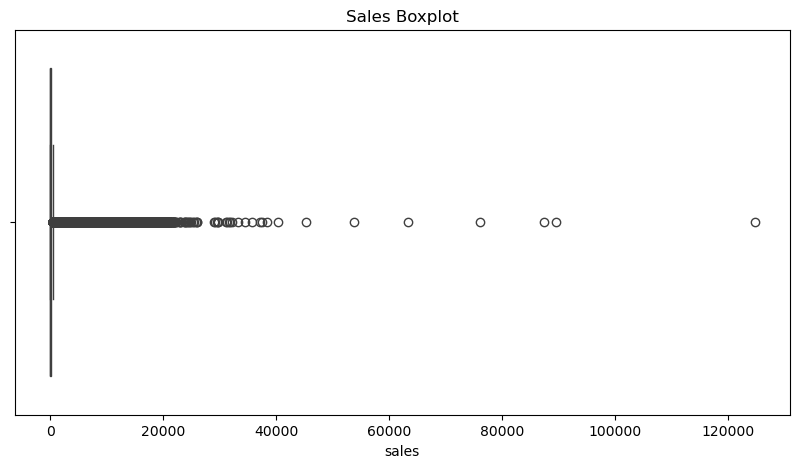

In [17]:
# Histogram of sales
plt.figure(figsize=(10,5))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Boxplot to see outliers
plt.figure(figsize=(10,5))
sns.boxplot(x='sales', data=train_df)
plt.title('Sales Boxplot')
plt.show()


In [74]:
"
1) Distribution of Sales (Histogram)

The histogram is heavily right-skewed.
- Most sales values are very small and clustered near zero.
- A long right tail stretches out to very large values (up to ~125,000).
This means:
- The majority of transactions are low-value sales
- A few very large sales exist, but they are rare
Because of those extreme values, the bars near zero look squashed — the outliers dominate the x-axis scale.

Key takeaway:
Sales are not normally distributed. They follow a long-tail distribution, which is common in revenue data.

2) Sales Boxplot

- The median is very close to the lower end of the scale.
- The interquartile range (IQR) is small, showing that the middle 50% of sales are tightly packed at low values.
- There are many outliers, extending far to the right.
- The whiskers are short on the low end and stretched on the high end, again confirming positive skewness.

Key takeaway:
Most sales are small, but there are numerous extreme high-value outliers that strongly affect the mean.

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ "                                                                                                │
│ ▲                                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: unterminated string literal (detected at line 1)

In [ ]:
##Time based Analysis

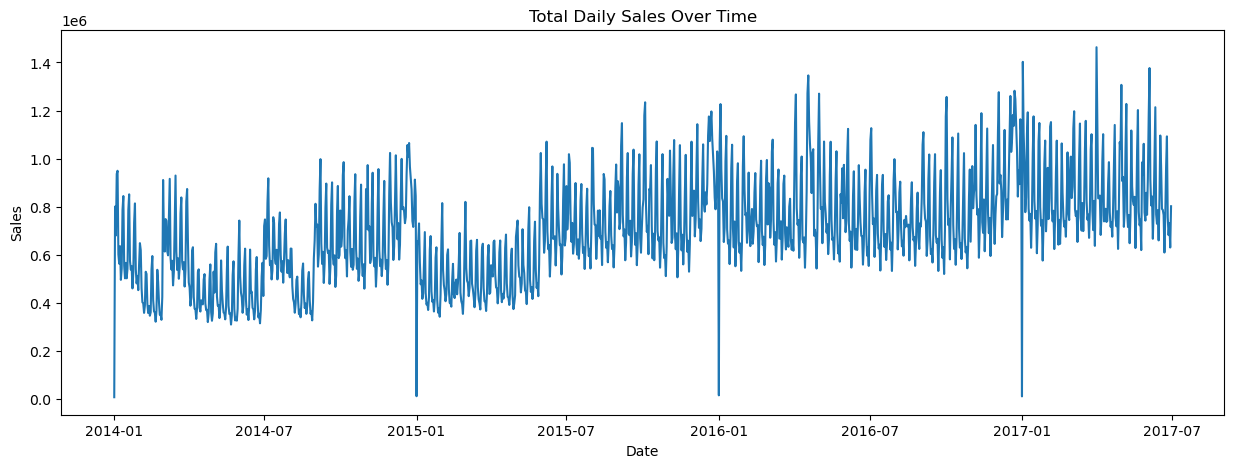

In [18]:
# Sales over time (total per day)
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=daily_sales, x='date', y='sales')
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


In [ ]:
1) Overall trend (big picture)

- Sales are increasing over time
- Early 2014 daily sales are mostly around 0.4–0.7 million
- By 2016–2017, they’re often around 0.7–1.1+ million

This suggests business growth over the years.

2) Strong seasonality / repeating pattern

You see regular up-and-down spikes at short intervals
- This looks like weekly seasonality:
- High sales on certain days (e.g., weekends or promo days)
- Lower sales on others

The pattern repeats consistently, which means demand is predictable.

3)Sudden sharp drops to near zero

There are very sharp dips around:
early 2014
early 2015
early 2016
early 2017

These drops are not normal behavior
- Most likely explanations:
- Store closures / holidays
- System or data recording issues
- Inventory or operational shutdowns

These are outliers, not true demand signals.

4) Increasing volatility

As sales grow, the size of the spikes also increases
This means:
- Higher revenue
- But also larger day-to-day fluctuations

This is common when a business scales.

Key interpretation in one go:

📈 Upward trend → growth
🔁 Clear seasonality → predictable cycles
⚠️ Extreme dips → anomalies or special events
📊 Variance increases with level → consider transformation

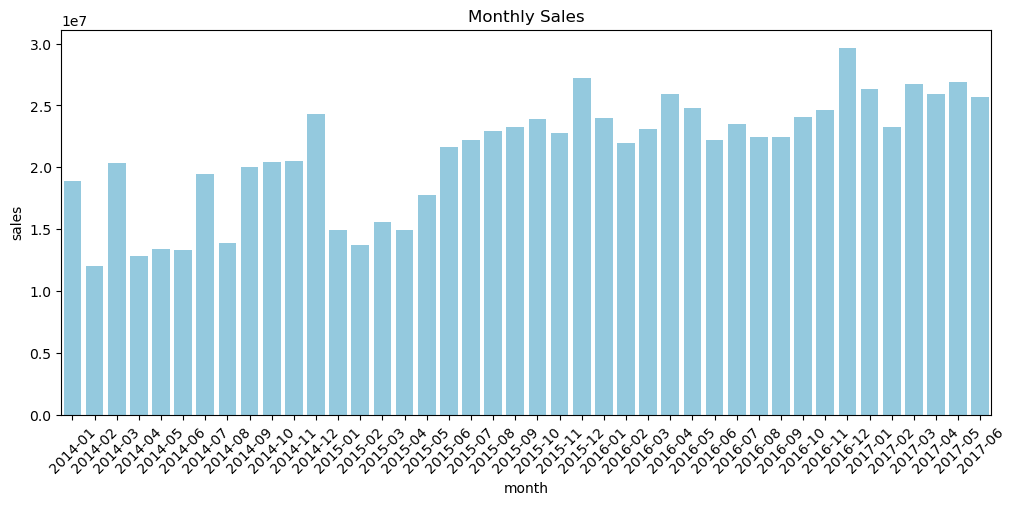

In [19]:
# weekly or monthly trends:
train_df['month'] = train_df['date'].dt.to_period('M')
monthly_sales = train_df.groupby('month')['sales'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=monthly_sales, x='month', y='sales', color='skyblue')
plt.title('Monthly Sales')
plt.xticks(rotation=45)
plt.show()

In [ ]:
"
1) Overall trend:

There is a clear upward trend in sales from 2014 to mid-2017.
- Early months (2014) are mostly around 12–20 million, while later months (2016–2017) often reach 24–30 million.

This suggests:
- Business growth over time
- Possible store expansion, product expansion, or inflation effects

Key takeaway: Sales are non-stationary (mean increases over time), which is important for time-series modeling.

2) Seasonality patterns:

You can see repeating ups and downs within each year.
- Sales tend to spike toward the end of the year (likely Nov–Dec).
- There are noticeable drops early in the year (Jan–Feb).

This aligns well with:
- Holiday shopping (Christmas, New Year)
- Year-end bonuses and promotions
- Post-holiday demand drop

Key takeaway: The data has strong yearly seasonality.

3) Notable peaks 

The highest bars appear around late 2016 and early 2017.
    
These could correspond to:

- Major holidays
- Promotions
- Economic or business growth factors

In the Corporación Favorita dataset, promotions (onpromotion) strongly impact sales, so these peaks may correlate with that.

4) Volatility over time:

- Sales fluctuations become larger in later years.
- Early years have smaller variation; later years swing more dramatically.

This suggests multiplicative seasonality, not additive.

Conclusion:
“The monthly aggregated sales from 2014 to 2017 show a clear upward trend, indicating long-term business growth. 
Additionally, recurring seasonal patterns are evident, with higher sales toward the end of each year and lower 
sales at the beginning. The increasing variance over time suggests multiplicative 
seasonality, which should be considered when selecting forecasting models.”

Based on this graph:

- Trend present → differencing or trend-aware models needed
- Strong seasonality → include yearly seasonality
- Increasing variance → consider log transformation

Good model choices:
- SARIMA / SARIMAX
- LightGBM / XGBoost with lag features

In [ ]:
##Sales by store and family

In [20]:
# Total sales per store
store_sales = train_df.groupby('store_nbr')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
print(store_sales.head())

# Total sales per family
family_sales = train_df.groupby('family')['sales'].sum().reset_index().sort_values(by='sales', ascending=False)
print(family_sales.head())


    store_nbr         sales
43         44  5.169214e+07
44         45  4.548050e+07
46         47  4.245425e+07
2           3  4.235580e+07
48         49  3.765839e+07
       family         sales
12  GROCERY I  2.735387e+08
3   BEVERAGES  1.861626e+08
30    PRODUCE  1.167709e+08
7    CLEANING  7.673183e+07
8       DAIRY  5.456876e+07


/tmp/ipykernel_523/3669547371.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_families, x='family', y='sales', palette='viridis')


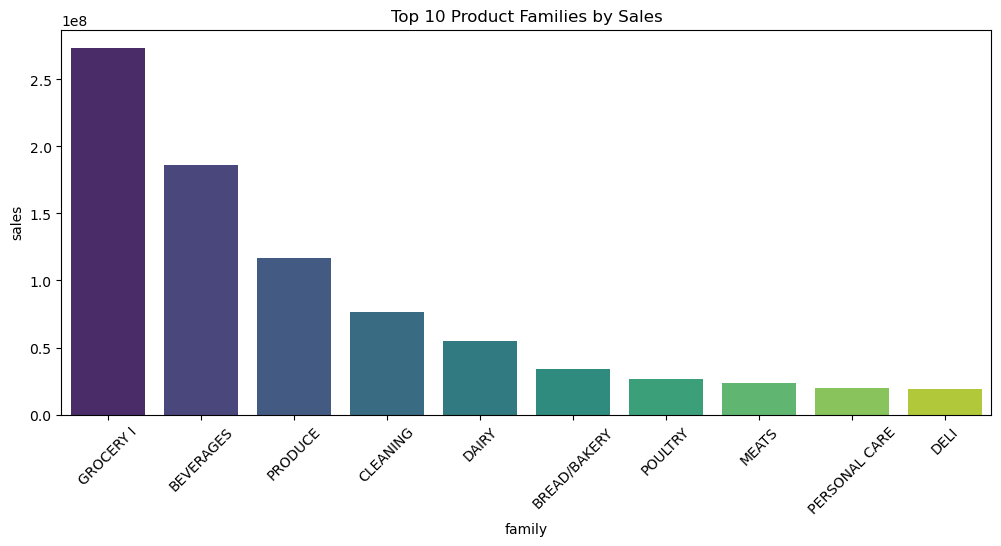

In [21]:
# Top 10 families
top_families = family_sales.head(10)
plt.figure(figsize=(12,5))
sns.barplot(data=top_families, x='family', y='sales', palette='viridis')
plt.title('Top 10 Product Families by Sales')
plt.xticks(rotation=45)
plt.show()


In [ ]:
"
This bar chart displays the Top 10 product families by total sales, aggregated from train.csv.

X-axis: Product family
Y-axis: Total sales (sum over time & stores)

Key insights from the graph:

1) Sales are highly concentrated (Pareto effect)
GROCERY I dominates all other categories by a large margin.
The top 3 families (GROCERY I, BEVERAGES, PRODUCE) contribute the majority of total sales.

This indicates a skewed distribution, where a few categories drive most revenue.

2) Daily-consumption items dominate

Top families are:
Staple foods
High-frequency purchase items
This makes sense for a grocery retailer:

- Grocery & beverages → bought often
- Produce → frequent replenishment
- Cleaning & dairy → recurring demand
- Lower families (deli, personal care) are:
- Less frequent purchases
- Smaller volume items

Implications for forecasting & modeling:

This graph tells you something important:
- Not all families behave the same
- GROCERY I will dominate error metrics if modeled poorly
Smaller families may have:
- More zero sales
- More noise
A single global model may struggle.
    
“The distribution of total sales across product families is highly skewed, with Grocery I contributing the largest share by a significant 
margin, followed by Beverages and Produce. This indicates that a small number of high-volume product families drive the majority of sales. Such imbalance suggests that product family is a critical feature for forecasting and that different families may require 
different modeling strategies.”

In [ ]:
##Promotions analysis

/tmp/ipykernel_523/3014416744.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['onpromotion'] > 0, 'sales'].sum() / x['sales'].sum())


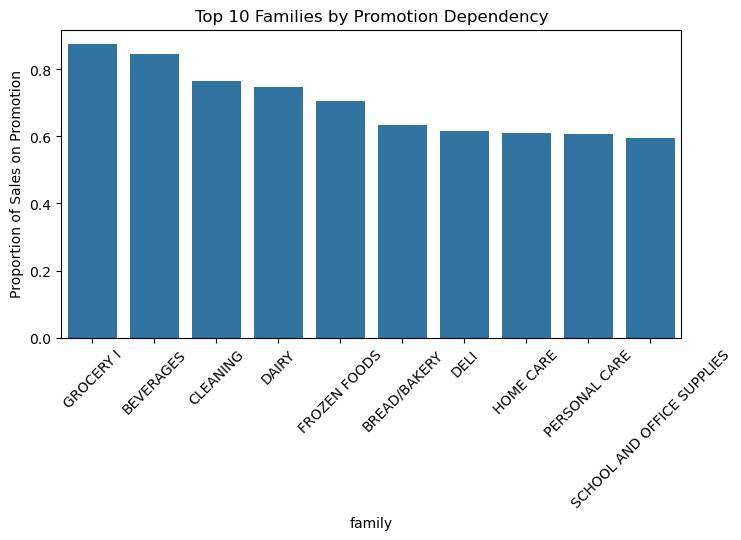

In [22]:
#How many sales were on promotion?
family_promo_ratio = (
    train_df.groupby('family')
    .apply(lambda x: x.loc[x['onpromotion'] > 0, 'sales'].sum() / x['sales'].sum())
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='promo_sales_ratio')
)

plt.figure(figsize=(8,4))
sns.barplot(data=family_promo_ratio, x='family', y='promo_sales_ratio')
plt.title('Top 10 Families by Promotion Dependency')
plt.ylabel('Proportion of Sales on Promotion')
plt.xticks(rotation=45)
plt.show()



In [ ]:
"
What this graph shows:

Title: Top 10 Families by Promotion Dependency
X-axis: Product families
Y-axis: Proportion of sales that occurred during promotions

So, for each family:
Promotion Dependency = (Sales when on promotion) / (Total sales)
A value of:
0.90 → 90% of sales happen on promotion
0.60 → 60% of sales happen on promotion

Extremely high promotion dependency overall:

1) All top families have > 60% of their sales coming from promotions.
This means:
- Promotions are not optional
- They are a primary demand driver.
Most promotion-dependent families.
Top families:
GROCERY I (~88%)
BEVERAGES (~85%)
CLEANING (~77%)
DAIRY (~74%)

These categories rely heavily on promotions to generate volume.

2) Lower (but still high) dependency families

BREAD/BAKERY, DELI, HOME CARE, PERSONAL CARE
- Still around 60–65%
- Even the least dependent families in the top 10:
- Majority of sales are promotional

3) Business interpretation 🛒

This suggests:
Customers are price-sensitive
- Promotions strongly influence buying decisions
- Many products may be over-promoted, leading to demand spikes

For a grocery retailer, this often means:
- Regular pricing plays a smaller role
- Promotion calendars are critical

“The proportion of sales occurring during promotional periods is consistently high across product families, exceeding 60% for all 
top categories. Grocery I and Beverages exhibit the strongest promotion dependency, with nearly 85–90% of sales 
driven by promotions. This highlights the critical role of promotional activity in shaping demand and suggests that promotion-related 
features must be explicitly modeled, potentially with family-specific effects.”

In [ ]:
##Correlation check

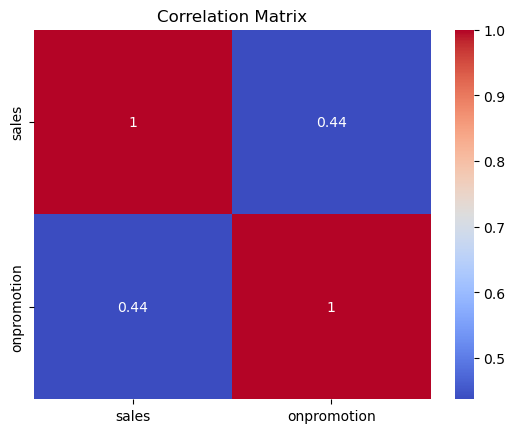

In [23]:
# Only numeric columns
numeric_cols = ['sales', 'onpromotion']
corr = train_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
"
What this means in simple terms:

- Promotions generally boost sales
However, promotions don’t fully explain sales
Other factors also matter:
- Seasonality
- Product family
- Store location
- Holidays
- Past sales (lags)

Promotions help, but they are not the only driver of demand.

Why the correlation is not higher (important insight)

Even though earlier plots showed high promotion dependency, the correlation is only 0.44 because:
Correlation measures linear relationship
Promotion effect can be nonlinear (big spikes)

Aggregation effect:
- Mixing all families, stores, and time periods
- Binary / count nature of onpromotion
- A product may be on promotion but sell very little

Lag effects:
- Promotion today may affect sales tomorrow

“The correlation analysis shows a moderate positive relationship (≈0.44) between 
sales and promotional activity, indicating that promotions are associated with increased sales. However, the correlation is not strong enough to explain sales dynamics on its own, suggesting that additional factors such as 
seasonality, product family, and historical sales also play significant roles.”

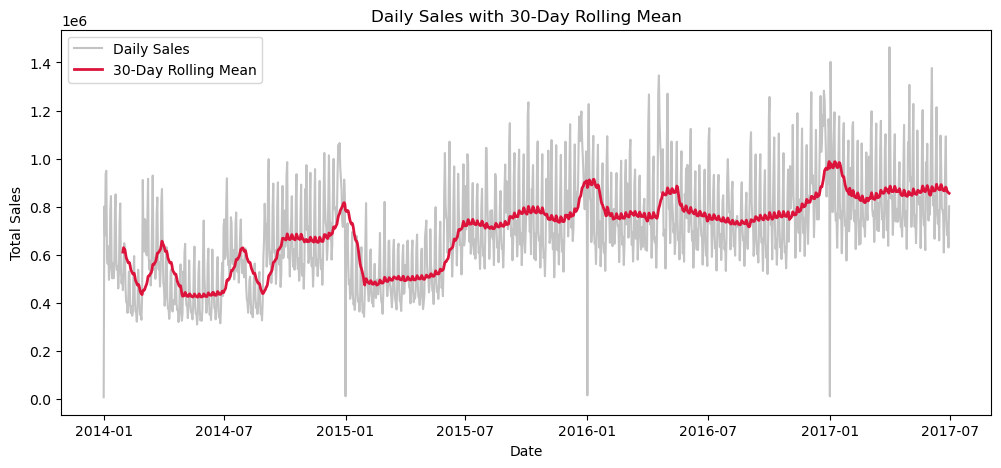

In [89]:
#Calculate 30-Day Rolling Mean
daily_sales["rolling_30"] = daily_sales["sales"].rolling(window=30).mean()
plt.figure(figsize=(12,5))

plt.plot(daily_sales["date"],
         daily_sales["sales"],
         alpha=0.4,
         color="dimgray",
         label="Daily Sales")

plt.plot(daily_sales["date"],
         daily_sales["rolling_30"],
         color="crimson",
         linewidth=2,
         label="30-Day Rolling Mean")

plt.title("Daily Sales with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()

plt.show()


In [ ]:
"
From the above graph,
- Grey line → Daily total sales (very noisy)
- Red line → 30-Day Rolling Mean (smoothed trend)

The red line gradually increases from 2014 → 2017.
👉 This means there is a positive yearly trend
- Sales are growing over time.
- So yes — a long-term upward trend exists.

Seasonal / Cyclical Patterns:

if we look at the repeating bumps:
Early 2014 → spike
Early 2015 → spike
Early 2016 → spike
Early 2017 → spike (big one)
👉 This suggests yearly seasonality.

There seems to be a strong increase around the beginning of each year.
Possibly:
- New Year
- Promotions
- Holiday carryover effects

Sudden Drops to Near Zero:
We can see sharp vertical drops in:
Early 2015
Early 2016
Early 2017
These are likely:
- Holidays
- Store closures
- Missing data days
- National events
These are NOT trend — they are special events or anomalies.

Volatility:

The grey daily sales are very noisy:
High day-to-day fluctuations
But the rolling mean smooths it nicely
This tells us:
- Daily variation is high
- But long-term movement is stable and predictable

Final Conclusion:
Your data shows:
✔ Strong upward long-term trend
✔ Clear yearly seasonality
✔ High daily volatility
✔ Event-based sudden drops

If we describe this in time-series terms:

👉 Trend + Seasonality + Noise present
👉 Likely multiplicative behavior (variance increases over time)

In [ ]:
##EDA for Stores.csv

In [24]:
#Read and do operations from data store in DataLake
query = f"""
SELECT *
FROM {database_name}.stores
LIMIT 10
"""
stores_df = pd.read_sql(query, conn)
stores_df


/tmp/ipykernel_523/662603630.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stores_df = pd.read_sql(query, conn)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [25]:
##Row count & uniqueness
query = f"""
SELECT COUNT(*) AS total_rows,
       COUNT(DISTINCT store_nbr) AS unique_stores
FROM {database_name}.stores
"""
pd.read_sql(query, conn)


/tmp/ipykernel_523/3499912853.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,total_rows,unique_stores
0,54,54


In [26]:
#Missing values check
query = f"""
SELECT
    SUM(CASE WHEN city IS NULL THEN 1 ELSE 0 END) AS city_nulls,
    SUM(CASE WHEN state IS NULL THEN 1 ELSE 0 END) AS state_nulls,
    SUM(CASE WHEN type IS NULL THEN 1 ELSE 0 END) AS type_nulls,
    SUM(CASE WHEN cluster IS NULL THEN 1 ELSE 0 END) AS cluster_nulls
FROM {database_name}.stores
"""
pd.read_sql(query, conn)


/tmp/ipykernel_523/4035017786.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,city_nulls,state_nulls,type_nulls,cluster_nulls
0,0,0,0,0


In [27]:
#Categorical distributions
query = f"""
SELECT type, COUNT(*) AS store_count
FROM {database_name}.stores
GROUP BY type
ORDER BY store_count DESC
"""
type_df = pd.read_sql(query, conn)
type_df


/tmp/ipykernel_523/2790236506.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  type_df = pd.read_sql(query, conn)


,type,store_count
0,D,18
1,C,15
2,A,9
3,B,8
4,E,4


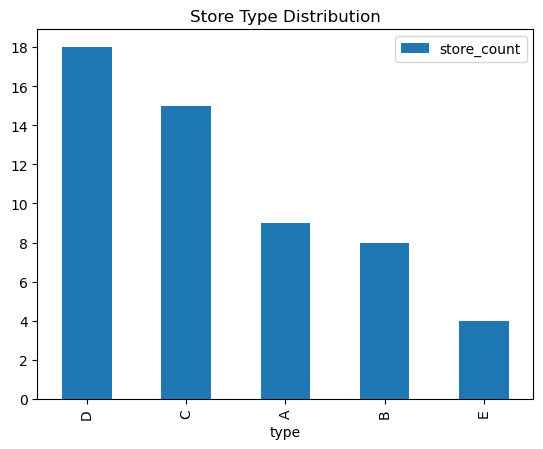

In [28]:
#BarPlot for storetype vs storecount 
ax = type_df.plot(kind='bar', x='type', y='store_count', title='Store Type Distribution')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [ ]:
"
From above graph i can see 
- store type D has maximum number of store count(18) and store type E has least number of store count(4)
- The chart shows the number of stores per store type, with Type D and Type C having the highest number of stores.

In [29]:
#Cluster distribution
query = f"""
SELECT cluster, COUNT(*) AS store_count
FROM {database_name}.stores
GROUP BY cluster
ORDER BY cluster
"""
cluster_df = pd.read_sql(query, conn)
cluster_df


/tmp/ipykernel_523/2991991013.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cluster_df = pd.read_sql(query, conn)


,cluster,store_count
0,1,3
1,2,2
2,3,7
3,4,3
4,5,1
5,6,6
6,7,2
7,8,3
8,9,2
9,10,6


In [ ]:
"
- Cluster is a group label that categorizes stores with similar characteristics.
Why cluster is useful for forecasting?
- Stores in the same cluster tend to:
- Have similar demand patterns
- Respond similarly to promotions
- Show similar seasonality
So cluster helps the model answer:

“How do stores like this usually behave?”

In [30]:
#State-level distribution
query = f"""
SELECT state, COUNT(*) AS store_count
FROM {database_name}.stores
GROUP BY state
ORDER BY store_count DESC
"""
state_df = pd.read_sql(query, conn)
state_df.head(10)

/tmp/ipykernel_523/4058907295.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  state_df = pd.read_sql(query, conn)


,state,store_count
0,Pichincha,19
1,Guayas,11
2,Santo Domingo de los Tsachilas,3
3,Azuay,3
4,Manabi,3
5,El Oro,2
6,Los Rios,2
7,Cotopaxi,2
8,Tungurahua,2
9,Chimborazo,1


In [ ]:
##EDA for transactions.csv

"
transactions = total number of customer transactions per store per day
This is:
- Time-varying
- Store-level
- Strong proxy for footfall / demand

In [31]:
query = f"""
SELECT *
FROM {database_name}.transactions
LIMIT 10
"""
transactions_df = pd.read_sql(query, conn)

transactions_df['date'] = pd.to_datetime(transactions_df['date'])
transactions_df

/tmp/ipykernel_523/176230168.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transactions_df = pd.read_sql(query, conn)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [32]:
#Statistical Analysis
transactions_df.describe()

,date,store_nbr,transactions
count,10,10.000000,10.000000
mean,2013-01-01 21:36:00,7.000000,2275.800000
min,2013-01-01 00:00:00,1.000000,770.000000
25%,2013-01-02 00:00:00,3.250000,1907.750000
50%,2013-01-02 00:00:00,5.500000,2127.000000
75%,2013-01-02 00:00:00,7.750000,2794.500000
max,2013-01-02 00:00:00,25.000000,3487.000000
std,NaN,6.831301,788.938499


In [62]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          10 non-null     datetime64[ns]
 1   store_nbr     10 non-null     int64         
 2   transactions  10 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 372.0 bytes


In [63]:
transactions_df.shape

(10, 3)

In [33]:
#Find any missing values present
transactions_df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [34]:
#How many stores have transaction data
transactions_df['store_nbr'].nunique()

10

In [35]:
transactions_df['date'].value_counts()

date
2013-01-02    9
2013-01-01    1
Name: count, dtype: int64

In [36]:
query = """
SELECT 
    MIN(date) AS min_date,
    MAX(date) AS max_date
FROM retail_forecasting.transactions
"""

pd.read_sql(query, conn)

/tmp/ipykernel_523/275077160.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,min_date,max_date
0,2013-01-01,2017-08-15


/tmp/ipykernel_523/2950677396.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_total = pd.read_sql(query, conn)


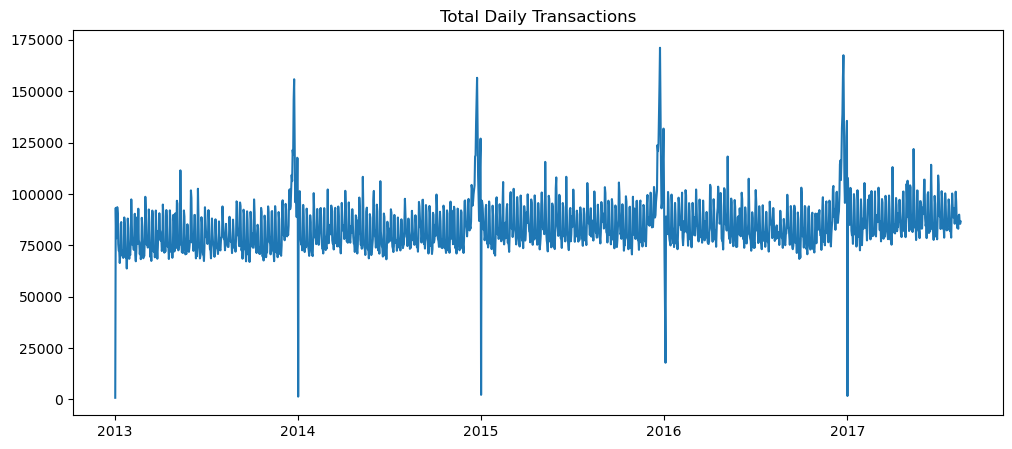

In [37]:
#Total transactions per day
query = """
SELECT 
    date,
    SUM(transactions) AS total_transactions
FROM retail_forecasting.transactions
GROUP BY date
ORDER BY date
"""

daily_total = pd.read_sql(query, conn)
daily_total.head()

plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(daily_total["date"]),
         daily_total["total_transactions"])
plt.title("Total Daily Transactions")
plt.show()

In [ ]:
"
From the above graph,
X-axis → Date (2013–2017)
Y-axis → Total Daily Transactions
Blue line → Raw daily transaction counts
This is the unsmoothed version (no rolling mean), so it looks noisy.

Overall Trend

Look at the general level:

2013 → around 75k–85k
2014 → slightly higher
2015 → higher
2016 → higher
2017 → highest baseline
👉 This shows a clear upward trend.
The business is growing year by year.

Yearly Seasonality (Very Clear):

Every year we see:
- A big spike
- Followed by a sharp drop close to zero
This happens around the same time each year.
👉 That means yearly seasonal pattern exists.

Likely reasons:
- New Year holiday
- Store closures
- Special national events
The repetition confirms seasonality.

Extreme Drops to Near Zero:

You see vertical drops:
Early 2013
Early 2014
Early 2015
Early 2016
Early 2017

These are probably:
- New Year (Jan 1)
- National shutdown days
- Missing data
These are not trend — they are event-driven anomalies.   

Volatility:

The daily line is very noisy:
- Large day-to-day movement
- Many small fluctuations
- That means high volatility.
Retail businesses usually behave like this.

Final Interpretation:

Your time series contains:

✔ Strong upward long-term trend
✔ Clear yearly seasonality
✔ Likely weekly seasonality
✔ High daily volatility
✔ Event-based extreme drops

Time Series Structure:

Your data looks like:
Trend + Seasonality + Noise + Special Events
This is typical for retail transaction data.

/tmp/ipykernel_523/307123486.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  top10_stores = pd.read_sql(query, conn)


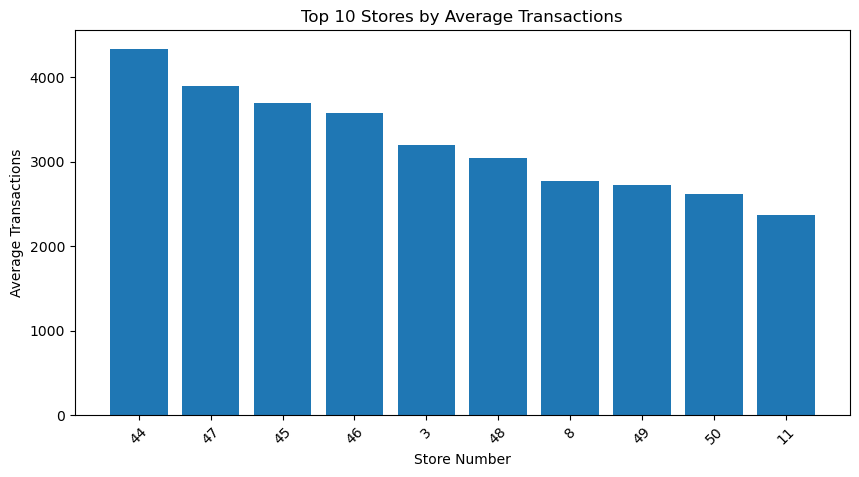

In [50]:
#Top 10 Stores by Average Transactions
query = """
SELECT 
    store_nbr,
    AVG(transactions) AS avg_transactions
FROM retail_forecasting.transactions
GROUP BY store_nbr
ORDER BY avg_transactions DESC
LIMIT 10
"""

top10_stores = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
plt.bar(top10_stores["store_nbr"].astype(str),
        top10_stores["avg_transactions"])

plt.title("Top 10 Stores by Average Transactions")
plt.xlabel("Store Number")
plt.ylabel("Average Transactions")
plt.xticks(rotation=45)
plt.show()


In [ ]:
"
From the above chart:

X-axis → Store number
Y-axis → Average daily transactions
Bars → Top 10 highest-performing stores (by average transactions)

Top Performer:
Store 44 has the highest average transactions (~4,300+).
👉 This store clearly outperforms the rest.

Possible reasons:
- Prime location
- Larger store size
- Higher foot traffic
- Better product mix

Strong Performers:

Next top stores:
- Store 47 (~3,900)
- Store 45 (~3,700)
- Store 46 (~3,600)

These stores form a high-performance cluster slightly below Store 44.
The gap between Store 44 and Store 47 is noticeable but not huge.

Mid–Upper Performers:
    
-Store 3 (~3,200)
-Store 48 (~3,050)
These stores are strong but clearly below the top tier.

Lower End of Top 10:

Store 8 (~2,800)
Store 49 (~2,750)
Store 50 (~2,600)
Store 11 (~2,350)

Even though they are in the top 10, there is a big difference between:
Store 44 (~4,300)
Store 11 (~2,350)

👉 That’s almost a 2,000 transaction gap.

Key Insights
✅ Performance Variation is Large
There’s significant spread between highest and lowest in top 10.
✅ Top Store Dominance
Store 44 is clearly a leader.
✅ Potential Benchmark Stores
Stores 44, 47, 45 could be used as benchmarks to:
- Compare staffing
- Analyze location advantages
- Study product assortment

Business Interpretation:

Investigate what makes Store 44 different
Replicate best practices in lower-performing stores
Check if top stores are in high-density urban areas
Compare store size vs transactions

/tmp/ipykernel_523/96462791.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  weekly_avg = pd.read_sql(query, conn)


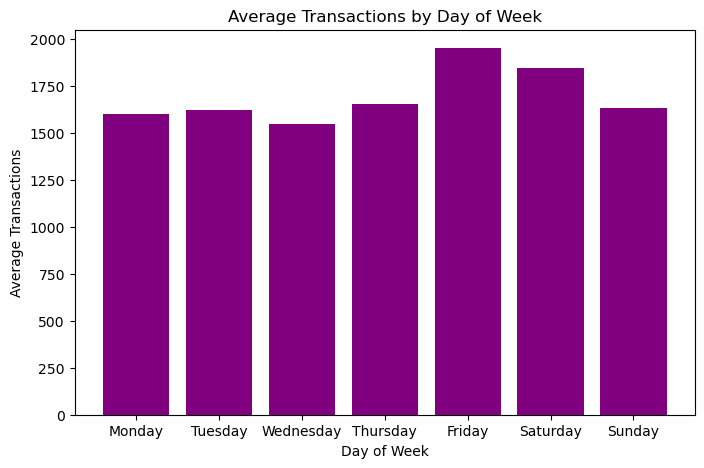

In [60]:
#Weekly Average Transactions
query = """
SELECT 
    day_of_week(date_parse(date, '%Y-%m-%d')) AS weekday_num,
    AVG(transactions) AS avg_transactions
FROM retail_forecasting.transactions
GROUP BY 1
ORDER BY 1
"""

weekly_avg = pd.read_sql(query, conn)

# Athena: 1=Sunday ... 7=Saturday
weekday_map = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}

weekly_avg["weekday"] = weekly_avg["weekday_num"].map(weekday_map)

# Reorder Monday → Sunday
order = ["Monday", "Tuesday", "Wednesday",
         "Thursday", "Friday", "Saturday", "Sunday"]

weekly_avg = weekly_avg.set_index("weekday").loc[order].reset_index()

plt.figure(figsize=(8,5))
plt.bar(weekly_avg["weekday"],
        weekly_avg["avg_transactions"],
       color = "purple")

plt.title("Average Transactions by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Transactions")
plt.show()


In [ ]:
"
What this shows

X-axis → Day of week
Y-axis → Average number of transactions
Bars → Average daily transaction volume

Key Observations:
    
- Friday is the Peak Day (~1950)
- Highest average transactions.
- Clear weekly peak.
- Likely payday effect, pre-weekend shopping, or promotions.
👉 This is the busiest day.

Saturday is Strong (~1850)

- Second highest.
- Weekend shopping behavior.
- Possibly family / bulk purchases.

Thursday is Rising (~1650)

- Noticeable increase from Wednesday.
- Customers likely preparing for weekend.

Midweek Dip (Tuesday & Wednesday)

- Wednesday is lowest (~1550).
- Tuesday slightly better than Monday.
- Midweek slowdown pattern.

Monday & Sunday Are Moderate:

- Monday (~1600): Normal business start.
- Sunday (~1630): Lower than Friday/Saturday but not weak.

Weekly Pattern (Seasonality Insight):

We have clear weekly seasonality:

- Low → Midweek (Wed)
- Rising → Thursday
- Peak → Friday
- High → Saturday
- Drop → Sunday
This forms a strong weekly demand cycle.

Business Implications:
Staffing:
- Increase staff on Friday & Saturday.
- Reduce staffing slightly on Wednesday.
Inventory:
- Stock up before Friday.
- Plan replenishment midweek.
Promotions:
- Run promotions midweek to lift Wednesday sales.
- Capitalize on Friday demand with bundles.

Overall Conclusion:

This business is:
- Weekend-driven
- Friday-heavy
- Exhibiting strong weekly seasonality
- Showing predictable demand cycles

/tmp/ipykernel_523/3895105918.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_avg = pd.read_sql(query, conn)


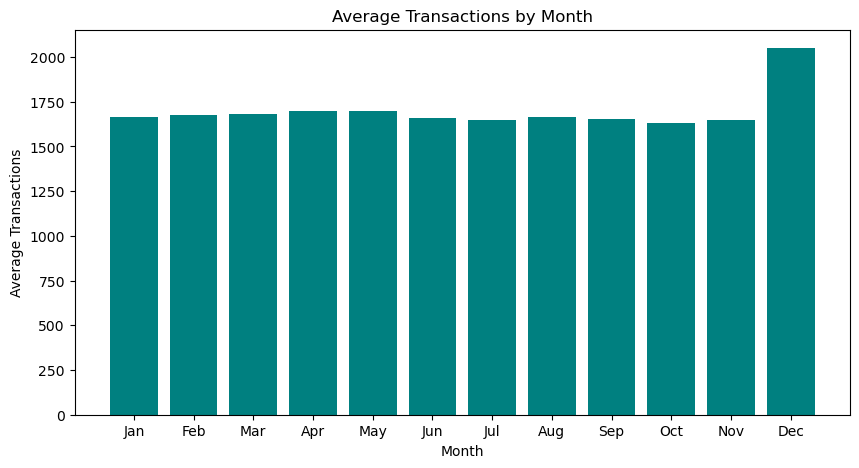

In [56]:
#Monthly Average Transactions (Jan → Dec)
query = """
SELECT 
    month(date_parse(date, '%Y-%m-%d')) AS month_num,
    AVG(transactions) AS avg_transactions
FROM retail_forecasting.transactions
GROUP BY 1
ORDER BY 1
"""

monthly_avg = pd.read_sql(query, conn)

# Map month numbers to names
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar",
    4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep",
    10: "Oct", 11: "Nov", 12: "Dec"
}

monthly_avg["month"] = monthly_avg["month_num"].map(month_map)

plt.figure(figsize=(10,5))
plt.bar(monthly_avg["month"],
        monthly_avg["avg_transactions"],
       color="teal")

plt.title("Average Transactions by Month")
plt.xlabel("Month")
plt.ylabel("Average Transactions")
plt.show()


In [ ]:
"
From the above graph,
Clear December Spike:
- December is significantly higher (~2050)
- All other months are clustered around 1650–1700
- The jump is large and consistent

Insight:

There is a strong yearly seasonality, especially a holiday-driven surge in December.
Likely causes:
- BaseExceptionChristmas shopping
- Year-end promotions
- Festive sales
- Bonus season spending
This is a predictable demand spike.

Stable Baseline (Jan–Nov):
Jan–Nov are relatively stable
Minor fluctuations
Slight increase in Apr–May
Slight dip around Jun–Oct

Insight:

Outside December, the business shows:
- Stable demand
- No extreme monthly volatility
- No strong mid-year seasonal peaks

This suggests:
Weekly seasonality > monthly seasonality (except December)

No Sharp Drop After December:

January is not dramatically low.
That means:
- No major post-holiday collapse
- Demand stabilizes quickly

What This Means for Feature Engineering:

1. Add Month Feature
df['month'] = df['date'].dt.month

2. Add December Flag (Very Important)
Since December behaves very differently:
df['is_december'] = (df['month'] == 12).astype(int)

3. Add Holiday / Promotion Features
Since December spike is likely event-driven:
df['is_holiday_season'] = df['month'].isin([11,12]).astype(int)

4. Cyclical Encoding for Month
Instead of raw month:
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
Because-
Captures yearly seasonality smoothly
Helps tree and linear models

5. Interaction Features (Advanced)
Since:
December spike exists
Fridays are already high (from weekly graph)
We can engineer:
df['december_friday'] = ((df['month']==12) & (df['day_of_week']==4)).astype(int)

This may capture:
Super high pre-Christmas Fridays.

Conclusion:
Monthly aggregation reveals a strong annual seasonality with a pronounced spike in December, likely driven by holiday demand and promotional events. 
The remaining months show relatively stable transaction levels. Therefore, month-based features, December indicators, and holiday season flags are 
introduced to capture yearly 
seasonal patterns.

/tmp/ipykernel_523/2269198889.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_yearly = pd.read_sql(query, conn)


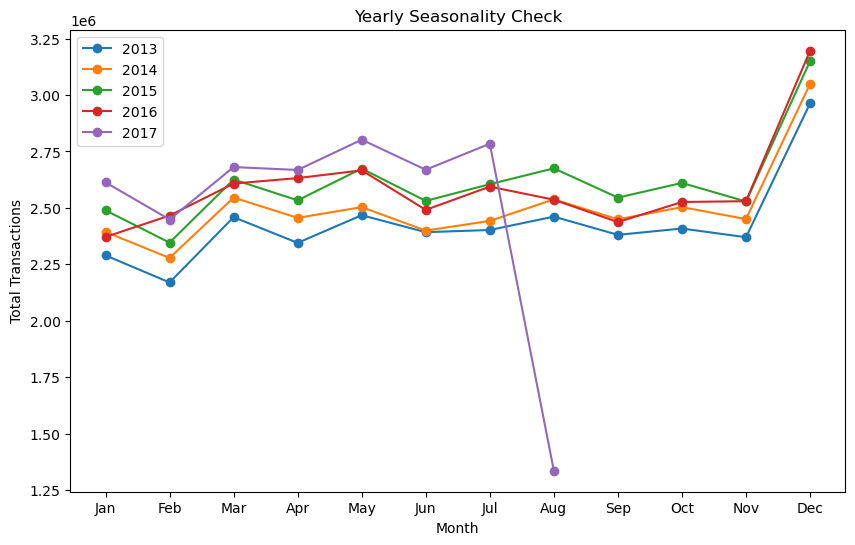

In [68]:
query = """
SELECT 
    year(date_parse(date, '%Y-%m-%d')) AS year,
    month(date_parse(date, '%Y-%m-%d')) AS month_num,
    SUM(transactions) AS total_transactions
FROM retail_forecasting.transactions
GROUP BY 1, 2
ORDER BY 1, 2
"""

monthly_yearly = pd.read_sql(query, conn)

month_map = {
    1: "Jan", 2: "Feb", 3: "Mar",
    4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep",
    10: "Oct", 11: "Nov", 12: "Dec"
}

monthly_yearly["month"] = monthly_yearly["month_num"].map(month_map)

plt.figure(figsize=(10,6))

for yr in monthly_yearly["year"].unique():
    data = monthly_yearly[monthly_yearly["year"] == yr]
    
    plt.plot(data["month"],
             data["total_transactions"],
             marker="o",
             label=str(yr))

plt.title("Yearly Seasonality Check")
plt.xlabel("Month")
plt.ylabel("Total Transactions")
plt.legend()
plt.show()


In [ ]:
"
X-axis → Month
Y-axis → Total Transactions
Each colored line → One year (2013–2017)

Every single year shows:

📈 Massive spike in December

2013 → ~2.97M
2014 → ~3.05M
2015 → ~3.15M
2016 → ~3.20M

This confirms:
December spike is NOT random — it is systematic yearly seasonality.

Consistent Monthly Pattern Shape:

Across 2013–2016, pattern is similar:
- Feb slightly lower
- March–May rising
- Small dip mid-year
- Gradual rise toward Q4
- Big jump in December

When different years follow similar shape → strong seasonal structure.
- Clear Upward Trend Year Over Year
- Each year (2013 → 2016) shifts slightly upward.

For example:
May 2013 < May 2014 < May 2015 < May 2016

This shows:
📈 Long-term growth trend.

So your data contains:
Trend component
Seasonality component

2017 August Collapse:

if we notice purple line (2017):
Huge drop in August.

- That is not seasonal.
- That is an external shock.

Very likely:
- Earthquake impact (if this is Ecuador retail dataset)
- absStore closures
- Data anomaly
This is an event-driven outlier, not seasonality.
Important for modeling.

Final Time Series Structure

Your data clearly contains:
✅ Long-term upward trend
✅ Strong yearly seasonality
✅ Strong weekly seasonality (from previous graph)
✅ Holiday-driven spikes

⚠️ Event-driven shocks

This is a multi-seasonal retail dataset.
    
What This Means for Feature Engineering?
    
1) Add Year Feature (Trend)
df['year'] = df['date'].dt.year

2) Add Month Feature (Yearly Seasonality)
df['month'] = df['date'].dt.month

3)Add Event / Shock Indicator (2017 August)

If earthquake period:

df['is_earthquake_period'] = ((df['date'] >= '2016-04-16') & 
                               (df['date'] <= '2016-05-31')).astype(int)

4) Add Lag Features (Very Important)

Since yearly pattern repeats:

df['lag_7'] = df['sales'].shift(7)
df['lag_30'] = df['sales'].shift(30)
df['lag_365'] = df['sales'].shift(365)

Conclusion:

Year-over-year monthly comparison confirms strong annual seasonality with consistent December peaks across all years. A gradual upward trend is 
observed from 2013 to 2016. An anomaly in August 2017 suggests event-driven disruption. Based on these insights, month-based features, lag variables,
trend indicators, and event flags will be engineered.

Important Modeling Insight:
    
Since your dataset shows:
- Multiple seasonalities (weekly + yearly)
- absNon-linear patterns
- Event shocks
Best models:
- XGBoost with lag features
- LightGBM

/tmp/ipykernel_523/3098046420.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_total = pd.read_sql(query, conn)


<Figure size 1000x500 with 0 Axes>

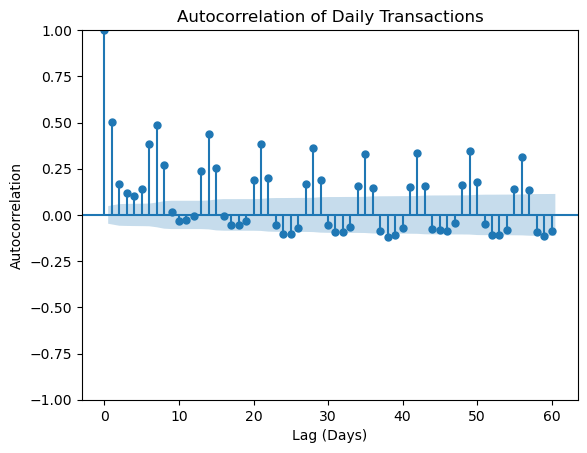

In [91]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import pandas as pd

query = """
SELECT 
    date,
    SUM(transactions) AS total_transactions
FROM retail_forecasting.transactions
GROUP BY date
ORDER BY date
"""

daily_total = pd.read_sql(query, conn)
daily_total["date"] = pd.to_datetime(daily_total["date"])

plt.figure(figsize=(10,5))

plot_acf(daily_total["total_transactions"], lags=60)

plt.xlabel("Lag (Days)")                     # X-axis = number of days back
plt.ylabel("Autocorrelation")                # Y-axis = correlation value
plt.title("Autocorrelation of Daily Transactions")

plt.show()


In [ ]:
"
What This ACF Plot Shows:
X-axis → Lag (Days)
Y-axis → Autocorrelation
Each vertical spike = correlation at that lag.

Each spike tells that:
How similar today’s transactions are to transactions X days ago.
If spikes are outside the blue band → statistically significant.

What Does the Blue Shaded Area Mean?
- That is the confidence interval.
- If spike goes outside it → statistically significant.

Meaning:
- The pattern is real, not random noise.

Why It’s NOT Saying “Exactly Equal”?
    
Important clarification:
Autocorrelation does NOT mean:
Exact same number.
It means:
- When one increases, the other also tends to increase.
- It measures similarity in movement, not exact value.

Why Lag 7 Is Important

If we see:

Lag 7 → high spike
Lag 14 → high spike
Lag 21 → high spike

That means:
- There is repetition every 7 days.
- Which is exactly weekly seasonality.

What Do Autocorrelation Values Mean?
Autocorrelation ranges from:
+1 → perfectly similar
0 → no relationship
-1 → opposite pattern

Example Interpretation

If lag 7 has value:
🔵 0.50
That means:

There is a strong positive relationship between today and 7 days ago.

When last Friday was high → this Friday is also high.
When last Monday was low → this Monday is also low.
We can say:
“This Friday behaves similar to last Friday.”
Because lag 7 corresponds to 7 days difference.

From above graph,

Strong Lag 7, 14, 21, 28 Pattern:

We can clearly see significant spikes at:

Lag 7
Lag 14
Lag 21
Lag 28
Lag 35
Lag 42
Lag 49
Lag 56

This is classic weekly seasonality.

Meaning:

Sales this Monday are similar to last Monday.
Sales this Friday are similar to last Friday.

This confirms:
✅ Strong 7-day cycle.

Bi-Weekly Pattern (Very Important):

You also see stronger correlation around:
Lag 14
Lag 28

Now we can connect this with note:
Public sector wages paid on 15th and last day of month.

This explains:
💰 Income-driven purchase cycle

Around 15th → spike
End of month → spike

Pattern repeats every ~14–15 days
That is why lag 14 shows structure.
This is behavioral seasonality, not calendar seasonality.
Very important insight.

Correlation Slowly Decays:

The autocorrelation gradually decreases as lag increases.
This suggests:
📈 There is also a trend component.
If there were no trend, ACF would drop quickly.

Negative Dips Between Cycles
Between spikes you see small negative correlations.
That happens because:
- High Friday → followed by low Monday
- Payday spike → followed by normalization
- That creates oscillation pattern.

Final Interpretation

Your time series has:

✅ Weekly seasonality (strongest)
✅ Bi-weekly wage effect
✅ Monthly effect (15th + end-of-month)
✅ Long-term trend
⚠️ External shock (earthquake 2016)

This is a complex multi-seasonal retail time series.

What This Means for Feature Engineering?
1) Add Day of Week Feature (Mandatory)
df['day_of_week'] = df['date'].dt.dayofweek  

2) Add Is_Payday Feature (Very Important)

Since wages are paid on:
- 15th
- Last day of month

df['day'] = df['date'].dt.day
df['is_15th'] = (df['day'] == 15).astype(int)

df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

This captures income shock effect.
This is advanced feature engineering.

Add Earthquake Flag
df['is_earthquake_period'] = (
    (df['date'] >= '2016-04-16') &
    (df['date'] <= '2016-05-31')
).astype(int)
So model does NOT treat it as seasonality.

Add Lag Features (From ACF Insight)

Because lag 7 and 14 are strong:

df['lag_7'] = df['transactions'].shift(7)
df['lag_14'] = df['transactions'].shift(14)
df['lag_28'] = df['transactions'].shift(28)


These are directly supported by your ACF.

Add Rolling Means
df['rolling_7'] = df['transactions'].rolling(7).mean()
df['rolling_14'] = df['transactions'].rolling(14).mean()

Captures smoothing behavior.

Conclusion:
Autocorrelation analysis reveals strong 7-day seasonality and significant 14-day correlation likely driven by bi-weekly wage payments 
(15th and month-end). The persistence across multiple lags confirms multi-seasonal behavior. External shock from April 2016 
earthquake introduces structural break, suggesting need for event indicator features. Based on these insights, lag features, calendar features, payday indicators, and event flags 
will be engineered.

/tmp/ipykernel_523/2509324834.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  daily_total = pd.read_sql(query, conn)


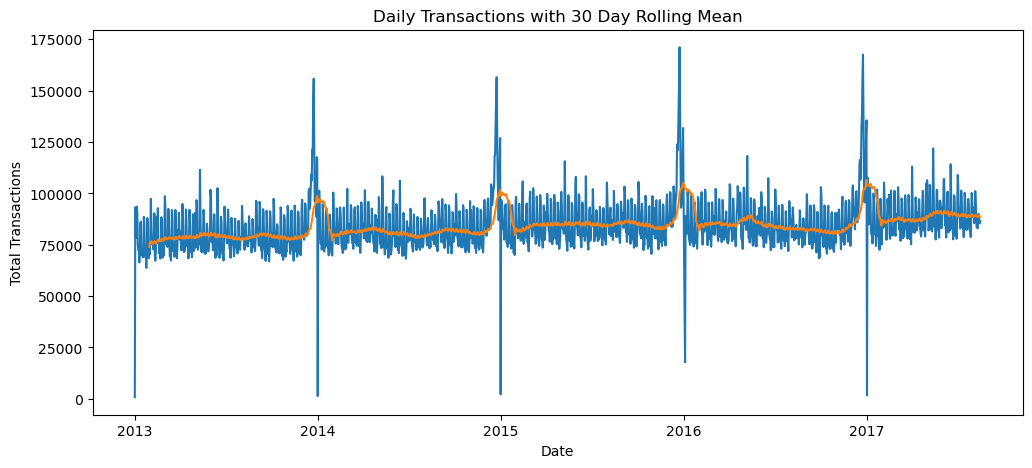

In [51]:
query = """
SELECT 
    date,
    SUM(transactions) AS total_transactions
FROM retail_forecasting.transactions
GROUP BY date
ORDER BY date
"""

daily_total = pd.read_sql(query, conn)
daily_total["date"] = pd.to_datetime(daily_total["date"])

# Rolling Means
#daily_total["rolling_7"] = daily_total["total_transactions"].rolling(window=7).mean()
daily_total["rolling_30"] = daily_total["total_transactions"].rolling(window=30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily_total["date"], daily_total["total_transactions"])
#plt.plot(daily_total["date"], daily_total["rolling_7"])
plt.plot(daily_total["date"], daily_total["rolling_30"])
plt.title("Daily Transactions with 30 Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Total Transactions")
plt.show()


In [ ]:
"
From the above graph,

Blue line → Daily total transactions
Orange line → 30-day rolling mean (smoothed trend)

Overall Trend (Long-Term Movement)

Look at the orange line:

2013 → around ~75k
2014 → slight increase
2015 → higher than 2014
2016 → stable but slightly increasing
2017 → clearly higher baseline (~85–90k)

✅ This shows gradual upward trend over years.

Interpretation:

Business is growing
More customers or store expansion
Demand increasing over time

Feature engineering idea:
- Add year
- Add time_index
- Add cumulative growth features

Extreme Drops (Almost to Zero)
Notice sharp drops near start of each year.
These are NOT real demand crashes.
Most likely:
January 1 (New Year holiday)
Store closed days

Feature engineering:
- is_holiday
- is_store_closed
- is_new_year
Very important for forecasting.

Big Spikes Each Year

Look at tall spikes:

End of 2013
End of 2014
End of 2015
End of 2016

These likely correspond to:
- Christmas season
- Year-end shopping

That shows strong yearly seasonality:

Feature ideas:
- is_december
- is_holiday_season
- days_to_christmas

Bi-Weekly / Salary Effect:
We can see repeating medium spikes regularly?

Salaries paid on 15th and month-end
So what happens?
Around:
15th
30th/31st
Transactions increase.
This creates:
- Small repeating bumps
- Seen clearly in rolling mean curve

2016 Earthquake Effect

Earthquake date:
📍 April 16, 2016

In 2016:After April → you see abnormal volatility
- Some unusual spikes
From notes:
People donated water and essentials
So demand for:
- Water
- Emergency goods
- likely surged for weeks.

📌 Feature idea:

- is_post_earthquake_period
- days_since_earthquake
This is critical for 2016 modeling.

Volatility:

Blue line shows:
- Large daily fluctuations
- Weekly oscillations
- Holiday spikes
This means:
- Strong short-term seasonality
- Non-constant variance
We may need:
- Log transform
- Rolling features
- Lag features

Final summary:

✔ Long-term upward trend
✔ Weekly seasonality
✔ Bi-weekly salary pattern
✔ Strong yearly seasonality (December peak)
✔ Special event shock (earthquake)
✔ Holiday closures

This is NOT random data.

It is structured time-series data with multiple cycles.

For Feature Store (Important):

We should create:
Time Features:
year
month
day_of_week
week_of_year
is_weekend

Lag Features:
lag_7
lag_14
lag_30

Rolling Features:
rolling_mean_7
rolling_mean_30
rolling_std_7
    
Event Features:
is_holiday
is_salary_day
is_post_earthquake

In [ ]:
##EDA for holidays_events table

In [69]:
query = """
SELECT COUNT(*) AS total_records
FROM retail_forecasting.holidays_events
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/3353317921.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,total_records
0,350


In [70]:
query = """
SELECT 
    MIN(date) AS min_date,
    MAX(date) AS max_date
FROM retail_forecasting.holidays_events
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/881197788.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,min_date,max_date
0,2012-03-02,2017-12-26


/tmp/ipykernel_523/4046260176.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  holidays_per_year = pd.read_sql(query, conn)


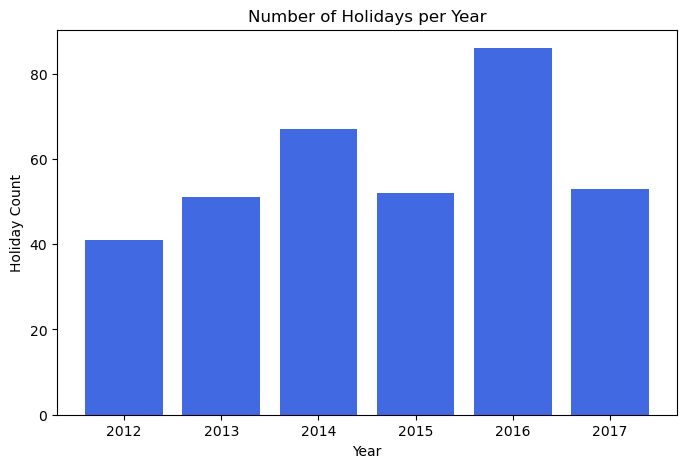

In [71]:
#Holidays Per Year
query = """
SELECT 
    year(date_parse(date, '%Y-%m-%d')) AS year,
    COUNT(*) AS holiday_count
FROM retail_forecasting.holidays_events
GROUP BY 1
ORDER BY 1
"""

holidays_per_year = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
plt.bar(holidays_per_year["year"],
        holidays_per_year["holiday_count"],
        color="royalblue")

plt.title("Number of Holidays per Year")
plt.xlabel("Year")
plt.ylabel("Holiday Count")
plt.show()


In [ ]:
"
X-axis: Year (2012–2017)
Y-axis: Number of holidays in that year

Approx values:

2012 → ~41
2013 → ~51
2014 → ~67
2015 → ~52
2016 → ~86 (very high)
2017 → ~53

1️⃣ Holidays are NOT constant across years

They vary a lot.
Especially:
2016 has very high holidays (~86)
2014 also higher than others
This means some years naturally have:
More long weekends
More special events
More public holidays

2️⃣ 2016 is an outlier

It has significantly more holidays than other years.
Now ask yourself:
👉 Did your sales also spike more in 2016?
If yes:
That means holiday effect is very strong in your dataset.

The number of holidays varies significantly across years, with 2016 having the highest holiday count. This variation suggests that
year-level demand fluctuations may be partially driven by calendar effects. Therefore, incorporating holiday-based features is necessary to capture year-specific 
demand changes.

Better Feature Ideas
2️⃣ Yearly Holiday Intensity

Create:
holiday_count_year
Or
holiday_ratio_year = holidays_in_year / 365
Holiday Impact Strength Feature
Create:
cumulative_holidays_ytd
(Year-to-date holiday count)
- This helps model understand:
- How many holidays already occurred this year.

3️⃣ Year × Holiday Interaction

Some years have more holidays.
Create:
is_holiday * year
Or better:
Use year as categorical variable

4️⃣ Detect Structural Break

If 2016 has both:
Highest holiday count
Sales spike
Then 2016 might behave differently.
You may need:
Year dummy variable
Or normalization

This graph proves:

✔ Holiday count varies yearly
✔ 2016 is unusually high
✔ Sales variation may be calendar-driven
✔ Holiday features are necessary
✔ Year-level controls are important

/tmp/ipykernel_523/1356995844.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  holidays_per_month = pd.read_sql(query, conn)


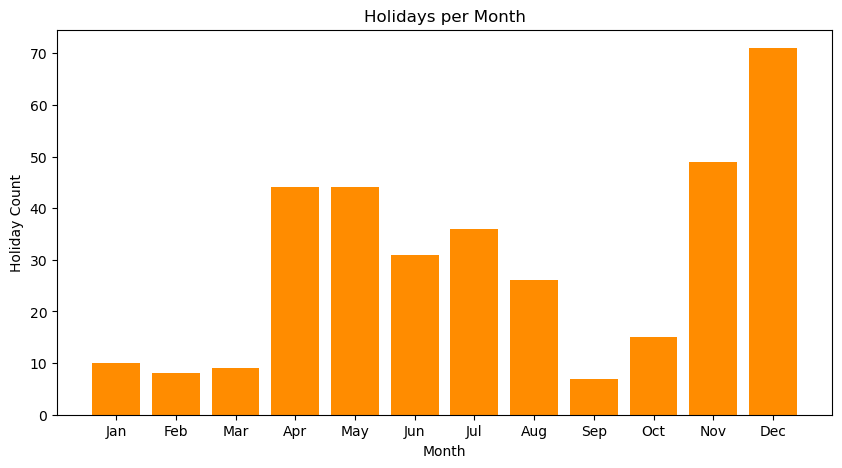

In [72]:
#Holidays Per Month (Seasonality Check)
query = """
SELECT 
    month(date_parse(date, '%Y-%m-%d')) AS month_num,
    COUNT(*) AS holiday_count
FROM retail_forecasting.holidays_events
GROUP BY 1
ORDER BY 1
"""

holidays_per_month = pd.read_sql(query, conn)

month_map = {
    1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
    7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"
}

holidays_per_month["month"] = holidays_per_month["month_num"].map(month_map)

plt.figure(figsize=(10,5))
plt.bar(holidays_per_month["month"],
        holidays_per_month["holiday_count"],
        color="darkorange")

plt.title("Holidays per Month")
plt.xlabel("Month")
plt.ylabel("Holiday Count")
plt.show()


In [ ]:
"
X-axis → Month (Jan–Dec)
Y-axis → Number of holidays in that month (across all years combined)

1) December has the highest holidays (~71)
Very strong spike.
Meaning:
- Christmas
- Year-end events
- Regional holidays
- Bridge holidays
- School holidays

💡 Interpretation:
December demand is heavily influenced by holidays.

This explains:
- December spikes in your sales graph earlier.

2) April & May are also high (~44)

Possible reasons:
- Easter
- Labor-related holidays
- Regional events
So Q2 also has many holiday effects.

3️) November is high (~49)

Likely:
- Independence-related holidays
- Local celebrations

4️) September very low (~7)

Almost no holidays.
This means:
- September sales patterns are more “normal”
- Less event-driven distortion

Sales are influenced by:

✔ Calendar seasonality
✔ Holiday clustering
✔ Not evenly distributed throughout year

Holidays are NOT random — they cluster in specific months.
That creates monthly seasonality.

Feature Engineering (Important):
    
️1) Holiday Density Feature:
Since December has 71 holidays across years, create:
holiday_count_in_month
or
holiday_ratio = holidays_in_month / total_days_in_month
This captures holiday intensity.

2) Interaction Features (Advanced):
You can combine:
is_salary_week * is_holiday

Holiday distribution is uneven across months, with December, November, April and May having significantly higher holiday counts.
This suggests strong calendar-driven seasonality in sales. Therefore, we engineer holiday intensity and proximity features to 
better capture event-driven demand fluctuations.



/tmp/ipykernel_523/1285423545.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  holiday_types = pd.read_sql(query, conn)


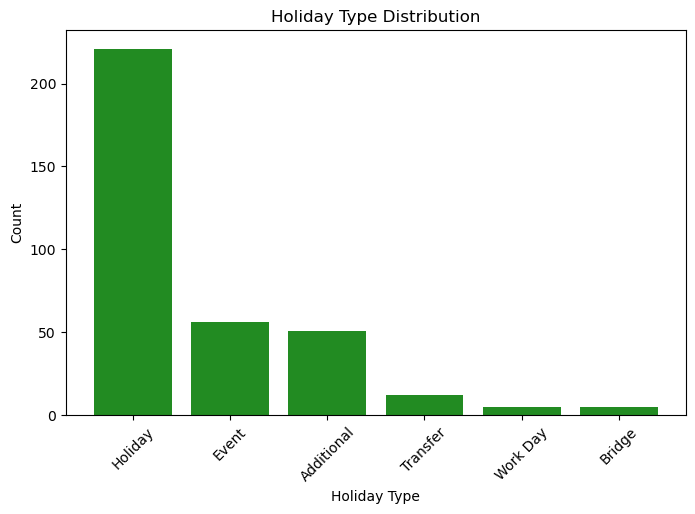

In [73]:
#Holiday Types Distribution
query = """
SELECT type,
       COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY type
ORDER BY count DESC
"""

holiday_types = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
plt.bar(holiday_types["type"],
        holiday_types["count"],
        color="forestgreen")

plt.title("Holiday Type Distribution")
plt.xlabel("Holiday Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
"
What this graph shows:
    
Holiday Types:
- Holiday
- Event
- Additional
- Transfer
- Work Day
- Bridge

Approximate counts:

🟢 Holiday ≈ 220+ (dominant)
🟡 Event ≈ 55
🟠 Additional ≈ 50
🔵 Transfer ≈ 12
🟣 Work Day ≈ 5
🟤 Bridge ≈ 5

Interpretation
1️⃣ "Holiday" dominates the dataset

This means:

✔ Most entries are official holidays
✔ Strong, recurring calendar signals
✔ Likely to cause consistent demand patterns

These are your most stable predictive features.

2️⃣ Events (~55)

These are things like:
Festivals
Special observances
Public celebrations

Events:
May increase traffic
But impact varies
Not always recurring annually

👉 Moderate predictive strength.

3️⃣ Additional (~50)

These are days added around main holidays (e.g., Christmas Eve).

Very important because:
They extend buying period
People shop before main holiday
Often cause spikes
These are HIGH IMPACT features.

4️⃣ Transfer (~12)

This is critical.
Transferred holidays:
Official holiday moved to another date
The original date behaves like normal day
The transferred date behaves like holiday
⚠ If you don’t handle this correctly, your model will learn wrong patterns.

We MUST:
Ignore original transferred date
Treat the transfer date as actual holiday

5️⃣ Bridge (~5)

Bridge days:
Artificial long weekends
Often increase shopping before/after
They can cause mini-spikes.

6️⃣ Work Day (~5)

These are payback days (usually Saturday made working day).
Impact:
Likely behaves more like weekday than weekend
Important to override default weekend logic

Recommended Feature Engineering

Instead of single flag, create:

✅ 1. One-hot encoding for holiday type
is_holiday
is_event
is_additional
is_transfer
is_bridge
is_work_day

✅ 2. Handle transfer properly

Logic:

If type == Transfer → mark this date as holiday
If original holiday had transferred=True → treat as normal day

This prevents data leakage / confusion.

✅ 3. Holiday intensity feature (advanced idea)

We could assign weights:

Major Holiday = 3
Additional = 2
Event = 1
Bridge = 1
Work Day = -1

Model may capture stronger effect.

Business Insight from This Plot:

The dataset is heavily calendar-driven.
Holiday seasonality is strong.
But there is complexity due to transfers and bridges.
Ecuador government policy affects demand timing.
This is VERY important for forecasting accuracy.

“The distribution shows that official holidays dominate the dataset, followed by events and additional holidays. 
Transfer and bridge days, though fewer, introduce calendar shifts that can distort weekly patterns. Therefore, holiday type-specencoding is necessary to accurately capture demand variation.”

In [74]:
#Transferred Holidays
query = """
SELECT transferred,
       COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY transferred
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/2027337911.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,transferred,count
0,True,12
1,False,338


In [75]:
#National vs Local Holidays
query = """
SELECT locale,
       COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY locale
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/1584742168.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,locale,count
0,Regional,24
1,National,174
2,Local,152


/tmp/ipykernel_523/2581948833.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  locale_dist = pd.read_sql(query, conn)


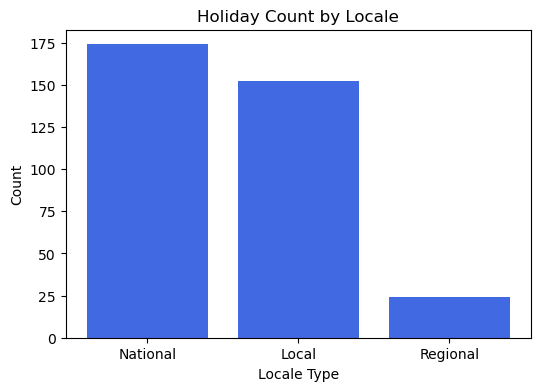

In [76]:
#Distribution of locale
query = """
SELECT 
    locale,
    COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY locale
ORDER BY count DESC
"""

locale_dist = pd.read_sql(query, conn)

plt.figure(figsize=(6,4))
plt.bar(locale_dist["locale"],
        locale_dist["count"],
        color="royalblue")

plt.title("Holiday Count by Locale")
plt.xlabel("Locale Type")
plt.ylabel("Count")
plt.show()


In [ ]:
"
Title: Holiday Count by Locale
X-axis: Locale Type
National
Local
Regional
Y-axis: Number of holidays

Approximate counts:

🟢 National ≈ 175
🟡 Local ≈ 150
🔵 Regional ≈ 25

1️⃣ National holidays are the most frequent

These holidays affect:
✔ All stores
✔ Entire country
✔ Entire customer base

This means:
When locale = National
👉 You expect demand impact across every store simultaneously

2️⃣ Local holidays are also very frequent

Local holidays (~150) are almost as many as national ones.
This means:
Different cities/locations experience holidays at different times.
So:
👉 Holiday impact is location-specific

3️⃣ Regional holidays are rare

Only about 25.
So:
They exist,But their overall impact on total aggregated sales is smaller
They matter more at regional/store level

Better Feature Engineering Strategy

Instead of one column:
is_holiday

You should create:
✅ 1. holiday_locale_type
Categorical variable:
National
Local
Regional
None

✅ 2. Separate binary flags
is_national_holiday
is_local_holiday
is_regional_holiday
This allows model to learn:
National holidays → large uniform spike
Local holidays → store-level spike
Regional holidays → moderate localized spike


✅ 3. Store-Holiday Matching (VERY POWERFUL)

For each store:
is_holiday_for_this_store
Because:
A local holiday in Quito should NOT affect a store in Guayaquil.
But a national holiday affects both.
This improves accuracy significantly.

Business Insight
This graph confirms:

✔ Holidays are not homogeneous
✔ Holiday impact is geographically structured
✔ Sales forecasting must be store-aware

If model ignores locale type,
it will average out effects → lower accuracy.


/tmp/ipykernel_523/651256527.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  locale_name_dist = pd.read_sql(query, conn)


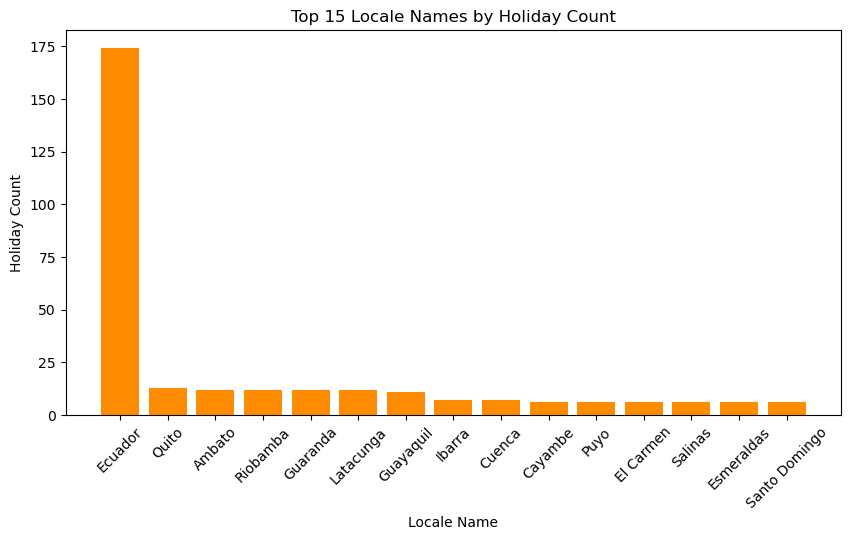

In [77]:
#Distribution of locale_name
query = """
SELECT 
    locale_name,
    COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY locale_name
ORDER BY count DESC
LIMIT 15
"""

locale_name_dist = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
plt.bar(locale_name_dist["locale_name"],
        locale_name_dist["count"],
        color="darkorange")

plt.title("Top 15 Locale Names by Holiday Count")
plt.xlabel("Locale Name")
plt.ylabel("Holiday Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
"
What This Graph Shows

Title: Top 15 Locale Names by Holiday Count

Y-axis → Number of holidays
X-axis → Locale name (country or city)

Main observation:
🇪🇨 Ecuador ≈ 175 holidays (VERY high)
Cities like:
Quito
Ambato
Riobamba
Guaranda
Latacunga
Guayaquil
→ Around 10–12 holidays each
Other cities → 6–8 holidays

Key Interpretation:

1️⃣ Ecuador dominates the count
This means:
These are National holidays.
They affect:
- All stores
- All cities
Entire demand system
So when locale_name = Ecuador, it’s basically a national holiday.
These will cause:
- Strong spikes or drops
- Clear sales pattern changes
- These are HIGH-impact features.

2️⃣ City-level holidays are much fewer

Each city has:
Around 6–12 local holidays
These:
- Affect only specific stores in that city
- Do NOT affect the entire country
- Have smaller but localized impact
Example:
- Quito holiday → only Quito stores affected
- Guayaquil holiday → only Guayaquil stores affected

Very Important Modeling Insight

This graph tells you:
- Holiday impact is hierarchical:
- National (affects all stores)
- Regional (affects group of stores)
- Local (affects specific city stores)

If you don’t merge holidays with store location correctly,
your model will:
- Assign holiday effect to wrong stores
- Learn noisy patterns
- Reduce accuracy

Feature Enginering:
    
✅ 1. National Holiday Feature
is_national_holiday
Apply to ALL stores on that date.

✅ 2. Local Holiday Feature
Merge:
store.city == holiday.locale_name
Then:
is_local_holiday
Only for stores in that city.

✅ 3. Regional Holiday Feature (if exists)
Match by state/region.

Business Insight:

This distribution shows:
Ecuador retail demand is strongly calendar-driven nationally.
Local festivities add smaller localized demand fluctuations.
Models must incorporate store-level geography.

/tmp/ipykernel_523/1534031855.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  locale_year = pd.read_sql(query, conn)


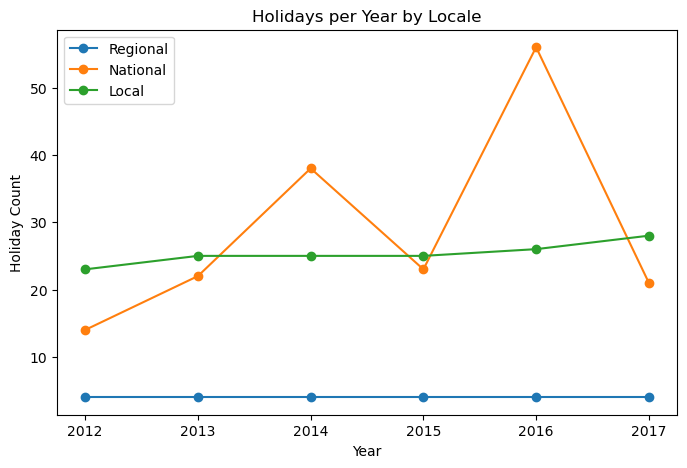

In [78]:
#Holidays by Locale per Year
query = """
SELECT 
    year(date_parse(date, '%Y-%m-%d')) AS year,
    locale,
    COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY 1, 2
ORDER BY 1
"""

locale_year = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))

for loc in locale_year["locale"].unique():
    data = locale_year[locale_year["locale"] == loc]
    plt.plot(data["year"],
             data["count"],
             marker="o",
             label=loc)

plt.title("Holidays per Year by Locale")
plt.xlabel("Year")
plt.ylabel("Holiday Count")
plt.legend()
plt.show()


In [ ]:
"
What This Graph Shows

Title: Holidays per Year by Locale
Y-axis → Holiday count
X-axis → Year (2012–2017)
Lines represent:

🔵 Regional
🟠 National
🟢 Local

Interpretation
1️⃣ Regional Holidays (Blue Line)

Almost flat (~4 each year)
Very small variation
Very low count compared to others
What this means:
- Regional holidays are:
- Rare
- Stable across years
- Low overall impact

👉 In modeling, this feature may have weaker influence unless stores are clustered by region.

2️⃣ Local Holidays (Green Line)

Very stable (23 → 28 range)
Slight gradual increase over years
No sudden jumps
What this means:
Local holidays are:
Consistent
Predictable
Stable year-to-year

👉 Good candidate for:

is_local_holiday
num_local_holidays_in_month
These will provide steady seasonal effects.

| Year | National Holidays |
| ---- | ----------------- |
| 2012 | Low (~14)         |
| 2013 | Moderate (~22)    |
| 2014 | High (~38)        |
| 2015 | Drop (~23)        |
| 2016 | Very High (~56)   |
| 2017 | Drop (~21)        |

2016 spike is huge.
This matches your earlier insight:

➡ 2016 = Earthquake year
➡ Possibly more national declarations
➡ More transferred/bridge holidays

Key Business Insight

National holidays are:
The most volatile category
The most impactful (affect all stores)
Strong driver of yearly variation in sales
This explains why:
Your yearly sales patterns differ across years.
Especially:
2016 likely shows abnormal demand behavior.
Important Modeling Insight:
This plot tells that:
Holiday count itself changes year-to-year.
So instead of just:
is_holiday = 1
We should engineer:

✅ 1. Holiday Density Features
holidays_in_month
holidays_in_year

✅ 2. National Holiday Intensity Feature
For each month:
num_national_holidays_in_month
This will help model:
December spike
2016 irregular pattern
Policy-driven changes

✅ 3. Earthquake-Specific Feature
Since 2016 national holidays spike:
Create:
post_earthquake_period = 1 (for X weeks after April 16, 2016)
Because:
The earthquake is NOT a normal seasonal pattern.
It’s a structural shock.

Very Important Observation:
This graph explains something subtle:
Your time series is NOT stationary across years.
Because:
2016 has structurally more national holidays
That changes total demand behavior
This is why:
Models like ARIMA alone may struggle
Tree-based models (XGBoost, LightGBM) with holiday features will perform better.

What This Means for Your Feature Store

For each (store_nbr, date) you should include:

is_national_holiday
is_local_holiday
is_regional_holiday
holidays_in_month
holidays_in_year
days_to_next_holiday
days_since_last_holiday
post_earthquake_flag
This will dramatically improve forecasting performance.

In [79]:
#Check National vs Non-National Ratio
query = """
SELECT 
    CASE 
        WHEN locale = 'National' THEN 'National'
        ELSE 'Non-National'
    END AS category,
    COUNT(*) AS count
FROM retail_forecasting.holidays_events
GROUP BY 1
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/3253128455.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,category,count
0,Non-National,176
1,National,174


In [ ]:
##EDA for oil table

In [81]:
query = """
SELECT *
FROM retail_forecasting.oil
ORDER BY date
LIMIT 5
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/3458889367.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [82]:
#Check Missing Values
query = """
SELECT 
    COUNT(*) AS total_rows,
    COUNT(dcoilwtico) AS non_null_values
FROM retail_forecasting.oil
"""

pd.read_sql(query, conn)


/tmp/ipykernel_523/307809382.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)


,total_rows,non_null_values
0,1218,1175


/tmp/ipykernel_523/2249650179.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  oil = pd.read_sql(query, conn)


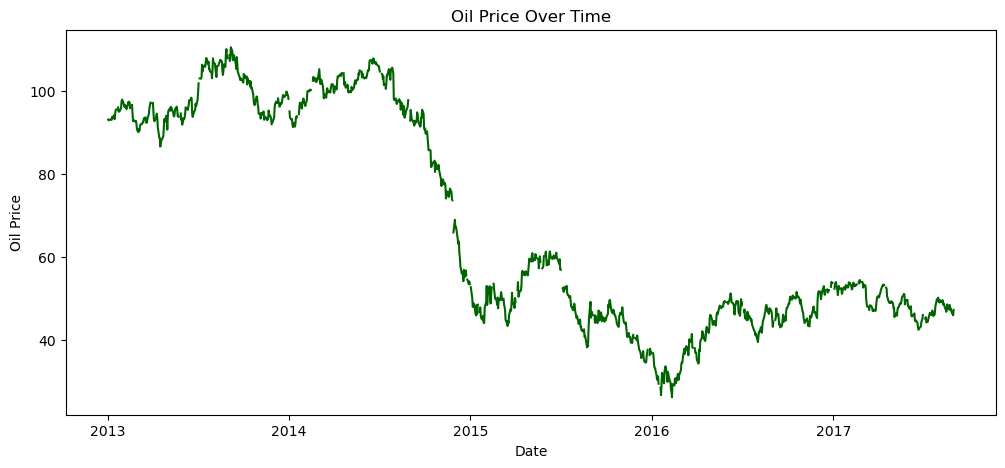

In [83]:
#Oil Price Trend Over Time
query = """
SELECT 
    date,
    dcoilwtico
FROM retail_forecasting.oil
ORDER BY date
"""

oil = pd.read_sql(query, conn)

plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(oil["date"]),
         oil["dcoilwtico"],
         color="darkgreen")

plt.title("Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()


In [ ]:
"
What This Graph Shows

Title: Oil Price Over Time (2013–2017)
Y-axis → Oil price
X-axis → Date

This is clearly a non-stationary time series with a structural break.

Key Observations:

1️⃣ 2013–Mid 2014: High & Stable Oil Prices (~90–110)

Oil price mostly above 90
Relatively stable with moderate volatility
Peak around 110

Interpretation:

Strong oil economy period.
Since Ecuador is an oil-exporting country:
Higher oil revenue
Higher government spending
More liquidity in economy
Potentially stronger consumer demand

2️⃣ Late 2014 – 2016: Major Crash 🚨

Oil drops sharply:

From ~105
To ~30–40

This is a massive structural shock.

Interpretation:

Economic slowdown likely
Reduced public spending
Lower consumer purchasing power
Possible reduction in supermarket demand
This coincides with:
2016 earthquake
High national holiday variation
Structural irregularities in sales
This period is economically unstable.

3️⃣ 2016–2017: Partial Recovery (~45–55)

Oil stabilizes but does NOT return to previous highs.
New lower equilibrium level.

Why This Is Important for Your Sales Forecasting?

Oil price affects:
Consumer confidence
Public sector salaries
Inflation
Government spending
Liquidity in economy
Which indirectly affects supermarket sales.
So oil is a leading macroeconomic feature.

Very Important Modeling Insight

This oil series has:

Trend
Structural break
Regime shift (2014 collapse)
If you ignore this, your model may:
- Overestimate demand in low-oil years
- Underestimate during high-oil years
    
Feature Engineering Recommendations

Instead of using raw oil price directly, engineer:

✅ 1️⃣ Lag Features
Consumer impact is delayed.
Create:
oil_price_lag_7
oil_price_lag_30
oil_price_lag_90

✅ 2️⃣ Rolling Mean Features

Smooth volatility:

oil_7d_avg
oil_30d_avg
oil_90d_avg
These capture macro trend better than daily price.

✅ 3️⃣ Oil Regime Feature (Very Powerful)

Create categorical regime:

oil_regime =
  High (>90)
  Medium (50–90)
  Low (<50)
This helps tree-based models learn nonlinear impact.

✅ 4️⃣ Oil Change Rate
oil_pct_change_7d
oil_pct_change_30d
Sudden drops (like 2014 crash) may affect behavior.

✅ 5️⃣ Structural Break Flag

Since major crash starts late 2014:
post_oil_crash_flag = 1 after Sept 2014
Because economy behaves differently after crash.

Combine This With Earthquake

Important:

2016 had:
Oil low
Earthquake
High national holidays
So 2016 is a multi-factor structural shock year.
Your model must capture:
economic_shock_period
Otherwise forecasts will struggle.

In [ ]:
"
Very Important Big Picture Insight
Your dataset is influenced by:
Weekly seasonality
Bi-weekly salary effect
Monthly/Yearly seasonality
Holiday effect
Earthquake shock
Oil price structural break
This is NOT a simple time series.
This is a:
Multi-factor demand forecasting problem.

/tmp/ipykernel_523/3890573105.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  yearly_oil = pd.read_sql(query, conn)


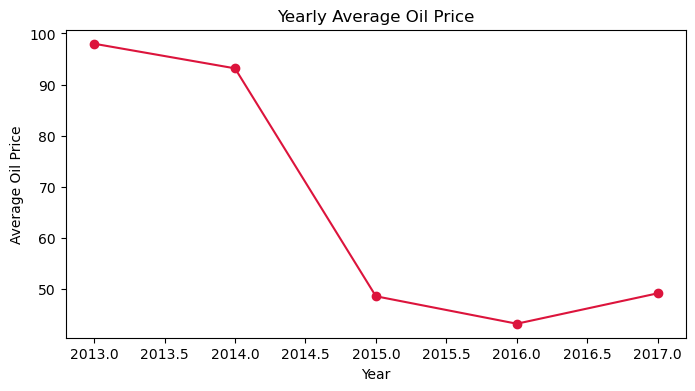

In [85]:
#Yearly Average Oil Price (Check Trend)
query = """
SELECT 
    year(date_parse(date, '%Y-%m-%d')) AS year,
    AVG(dcoilwtico) AS avg_price
FROM retail_forecasting.oil
GROUP BY 1
ORDER BY 1
"""

yearly_oil = pd.read_sql(query, conn)

plt.figure(figsize=(8,4))
plt.plot(yearly_oil["year"],
         yearly_oil["avg_price"],
         marker="o",
         color="crimson")

plt.title("Yearly Average Oil Price")
plt.xlabel("Year")
plt.ylabel("Average Oil Price")
plt.show()


In [ ]:
"
What This Graph Shows:
Yearly Average Oil Price (2013–2017)

| Year | Approx Avg Price |
| ---- | ---------------- |
| 2013 | ~98              |
| 2014 | ~93              |
| 2015 | ~49              |
| 2016 | ~43              |
| 2017 | ~49              |

Key Observations
1️⃣ 2013–2014: High Oil Regime

Oil prices are very high (above 90).
This suggests:
Strong oil revenue
Stronger economy (for oil-exporting country)
Possibly stronger consumer spending

2️⃣ 2015: Major Structural Crash

Huge drop from ~93 → ~49

That is almost a 50% collapse.
This is not normal fluctuation.
This is a structural break.

In time series terms:
Mean level changed permanently
Distribution shifted
Variance regime changed
Your model must handle this.

3️⃣ 2016: Lowest Point

Oil bottoms around ~43.

This likely corresponds to:
Economic slowdown
Reduced purchasing power
Possible drop in retail demand

4️⃣ 2017: Partial Recovery

Slight rebound to ~49.

But notice:
It never returns to 2013–2014 levels.
That means:
The economy moved into a new oil price regime.

/tmp/ipykernel_523/200981396.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  monthly_oil = pd.read_sql(query, conn)


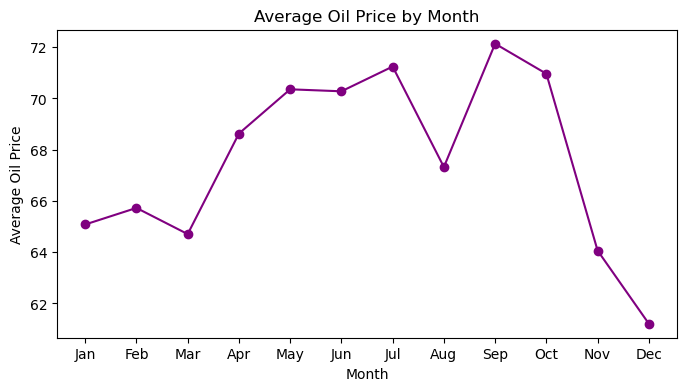

In [86]:
#Monthly Average Oil Price
query = """
SELECT 
    month(date_parse(date, '%Y-%m-%d')) AS month,
    AVG(dcoilwtico) AS avg_price
FROM retail_forecasting.oil
GROUP BY 1
ORDER BY 1
"""

monthly_oil = pd.read_sql(query, conn)

month_labels = ['Jan','Feb','Mar','Apr','May','Jun',
                'Jul','Aug','Sep','Oct','Nov','Dec']

monthly_oil["month_name"] = monthly_oil["month"].apply(lambda x: month_labels[x-1])

plt.figure(figsize=(8,4))
plt.plot(monthly_oil["month_name"],
         monthly_oil["avg_price"],
         marker="o",
         color="purple")

plt.title("Average Oil Price by Month")
plt.xlabel("Month")
plt.ylabel("Average Oil Price")
plt.show()


In [ ]:
"
Interpretation: Average Oil Price by Month:
| Month   | Behavior      |
| ------- | ------------- |
| Jan–Mar | Slight dip    |
| Apr–Jul | Rising        |
| Aug     | Drop          |
| Sep     | Peak          |
| Oct     | Slight drop   |
| Nov–Dec | Sharp decline |

What This Means

This graph shows seasonality in oil price.
Oil price tends to:
Increase from spring to late summer
Peak around September
Fall toward end of year
This is a seasonal macroeconomic pattern.

Important Question for Your Forecasting Model

Does oil price have:
Yearly seasonality?
Structural break (2014 crash)?
Trend over time?
The answer is: YES to all three.
So oil is:

✔ Trend component
✔ Seasonal component
✔ Structural shock component


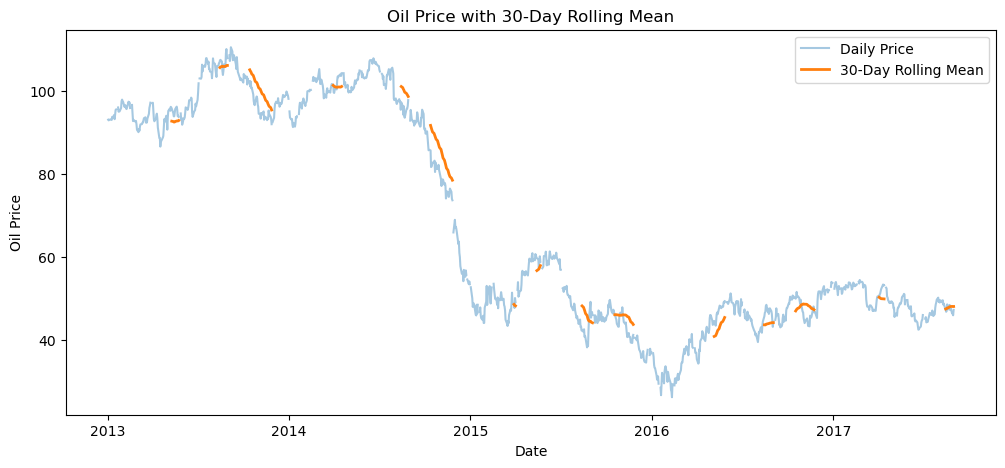

In [90]:
#Rolling 30-Day Mean (Smooth Trend)
oil["date"] = pd.to_datetime(oil["date"])
oil = oil.sort_values("date")

oil["rolling_30"] = oil["dcoilwtico"].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(oil["date"], oil["dcoilwtico"], alpha=0.4, label="Daily Price")
plt.plot(oil["date"], oil["rolling_30"], linewidth=2, label="30-Day Rolling Mean")

plt.title("Oil Price with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.legend()
plt.show()


In [ ]:
"
What This Graph Shows

Blue line → Daily oil price
Orange line → 30-day rolling mean (smoothed trend)

The rolling mean removes daily noise and shows the underlying direction.

Phase-by-Phase Interpretation
🟢 Phase 1: 2013 – mid 2014 (Stable High Regime)

Oil fluctuates between ~90–110
Rolling mean is mostly flat or slightly upward
Trend is stable

👉 Interpretation:
Economy is stable and strong (for oil-exporting country).
    
Phase 2: Late 2014 – Early 2015 (Sharp Structural Break)
This is the most important part.
Look at:

Blue line drops sharply
Orange rolling mean slopes downward steeply
That steep orange slope tells you:
This is not noise. This is a persistent downward trend.
This confirms a structural break.

Phase 3: 2015 – Early 2016 (Low Regime + Volatility)

Prices fall to ~30–60
Rolling mean continues downward then stabilizes
High volatility
This means:
Economy likely under stress
Consumer demand may weaken
Business uncertainty increases

Phase 4: 2016–2017 (Partial Recovery, New Regime)

Oil stabilizes around 45–55
Rolling mean flattens

Important:
It does NOT return to 100.
So we now have:
Old regime (90–110)
New regime (40–60)
Very different economic environments.

Feature Engineering Insights (This Is What You Should Do)

Instead of using raw oil price, engineer:
1️⃣ Rolling Features

You already created 30-day mean.

Also create:
90-day rolling mean
180-day rolling mean
30-day rolling std (volatility)

Why?
Retail demand responds slowly, not instantly.

Lagged Oil Features

Consumer demand reacts with delay.
Create:

oil_lag_30
oil_lag_60
oil_lag_90

Very powerful for retail forecasting.

Volatility FeatureL

During 2015–2016 volatility is high.
Create:
oil_volatility_30 = rolling_std(30)
High volatility → uncertainty → cautious spending.

mportant Modeling Insight

This graph proves:

Oil price is NOT seasonal.
Oil price is NOT stationary.
Oil price has structural breaks.

So:
Do NOT just feed raw oil.
Engineer macro regime features.
Consider normalizing oil by regime.

The 30-day rolling mean reveals a significant structural break beginning in late 2014, where oil prices entered a prolonged downward trend. 
This indicates a macroeconomic regime shift that may impact retail demand. Therefore, engineered oil features such as rolling averages, 
lagged values, and volatility measures will be incorporated into 
the feature store.
